In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 30
pd.options.display.max_columns = 60

In [2]:
# !pip install shap
# !pip install lightgbm

In [3]:
df = pd.read_csv('match_data.csv')
df = df[df['league']=='LCK'].copy()
df.reset_index(drop=True, inplace=True)
columns = list(df.columns)

In [4]:
df.shape

(5868, 121)

In [5]:
summary_df = df.copy()

summary_df['killsdiffat15'] = summary_df['killsat15'] - summary_df['opp_killsat15']
summary_df['assistsdiffat15'] = summary_df['assistsat15'] - summary_df['opp_assistsat15']
summary_df['deathsdiffat15'] = summary_df['deathsat15'] - summary_df['opp_deathsat15']

summary_col_list = ['playername','position',
 'golddiffat15','xpdiffat15','csdiffat15',
 'killsdiffat15','assistsdiffat15','deathsdiffat15',
 'damagetochampions','damageshare',
 'damagemitigatedperminute', 'wardsplaced','wardskilled',
 'controlwardsbought','visionscore','totalgold','total cs','monsterkills',
 'monsterkillsownjungle','monsterkillsenemyjungle','firstblood',
 'firstdragon','dragons','elders','firstherald',
 'heralds','firstbaron','barons','firsttower','towers',
 'result']

time_col_list = ['damagetochampions','damageshare',
 'damagemitigatedperminute', 'wardsplaced','wardskilled',
 'controlwardsbought','visionscore','totalgold','total cs','monsterkills',
 'monsterkillsownjungle','monsterkillsenemyjungle']

for col in time_col_list:
    summary_df[col] = summary_df[col]/summary_df['gamelength']

summary_df = summary_df[summary_col_list].copy()

In [6]:
top_df = summary_df[summary_df['position']=='top'].copy()
top_df = top_df.drop(columns=['position'])
top_df = top_df.reset_index(drop=True)
top_df = top_df.dropna(axis=1)

mid_df = summary_df[summary_df['position']=='mid'].copy()
mid_df = mid_df.drop(columns=['position'])
mid_df = mid_df.reset_index(drop=True)
mid_df = mid_df.dropna(axis=1)

jng_df = summary_df[summary_df['position']=='jng'].copy()
jng_df = jng_df.drop(columns=['position'])
jng_df = jng_df.reset_index(drop=True)
jng_df = jng_df.dropna(axis=1)

bot_df = summary_df[summary_df['position']=='bot'].copy()
bot_df = bot_df.drop(columns=['position'])
bot_df = bot_df.reset_index(drop=True)
bot_df = bot_df.dropna(axis=1)

sup_df = summary_df[summary_df['position']=='sup'].copy()
sup_df = sup_df.drop(columns=['position'])
sup_df = sup_df.reset_index(drop=True)
sup_df = sup_df.dropna(axis=1)

team_df = summary_df[summary_df['position']=='team'].copy()
team_df = team_df.drop(columns=['position'])
team_df = team_df.reset_index(drop=True)
team_df = team_df.dropna(axis=1)

In [7]:
top_df.head(5)

,playername,golddiffat15,xpdiffat15,csdiffat15,killsdiffat15,assistsdiffat15,deathsdiffat15,damagetochampions,damageshare,damagemitigatedperminute,wardsplaced,wardskilled,controlwardsbought,visionscore,totalgold,total cs,monsterkills,firstblood,result
0,Rascal,1548.0,1464.0,-8.0,3.0,1.0,-4.0,10.228296,0.000157,0.349910,0.005053,0.011024,0.003675,0.023886,8.448323,0.153881,0.023886,1.0,1
1,Doran,-1548.0,-1464.0,8.0,-3.0,-1.0,4.0,5.097382,0.000091,0.211967,0.010106,0.003215,0.005053,0.014240,4.858521,0.114837,0.000000,0.0,0
2,Doran,-725.0,-117.0,-4.0,-1.0,-2.0,1.0,11.943889,0.000175,0.486796,0.007778,0.001667,0.002222,0.012778,5.923889,0.141667,0.005556,0.0,0
3,Rascal,725.0,117.0,4.0,1.0,2.0,-1.0,8.475000,0.000126,0.494778,0.005000,0.002222,0.002778,0.010000,7.975556,0.154444,0.008889,0.0,1
4,Canna,-152.0,420.0,-14.0,0.0,1.0,-1.0,3.866955,0.000101,0.269147,0.005408,0.001622,0.002704,0.012980,6.266631,0.131963,0.005949,1.0,1


In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

def encoder(df):
    le = LabelEncoder()
    labels = le.fit_transform(df.iloc[:,0])
    df.iloc[:,0] = labels
    return df

top_df = encoder(top_df)
mid_df = encoder(mid_df)
jng_df = encoder(jng_df)
bot_df = encoder(bot_df)
sup_df = encoder(sup_df)



def scaler(df):
    scaler = MinMaxScaler()
    df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])
    return df

top_df = scaler(top_df)
mid_df = scaler(mid_df)
jng_df = scaler(jng_df)
bot_df = scaler(bot_df)
sup_df = scaler(sup_df)

In [9]:
# pip install lightgbm

In [10]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

ftr = jng_df.drop(columns=['result'])
target = jng_df.result

X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

lgbm_warpper = LGBMClassifier(verbose=0)

evals = [(X_test, y_test)]
lgbm_warpper.fit(X_train, y_train, early_stopping_rounds = 100,
                eval_metric='logloss', eval_set = evals, verbose = True)
preds = lgbm_warpper.predict(X_test)

C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.641214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.598352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_logloss: 0.563926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_logloss: 0.535652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's binary_logloss: 0.508897
[6]	valid_0's binary_logloss: 0.487609
[LightGBM] [Warning] No further splits with positive gain, best ga

In [11]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lgbm_warpper, ftr, target, scoring = 'accuracy', cv=5)
print('교차 검증 정확도 : {}'.format(sum(scores/5)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

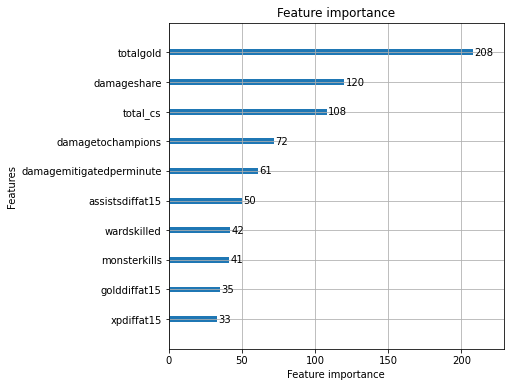

In [12]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
f, ax = plt.subplots(figsize=(6, 6))
plot_importance(lgbm_warpper, max_num_features=10, ax=ax)

<AxesSubplot:title={'center':'Person Correlation of Features'}>

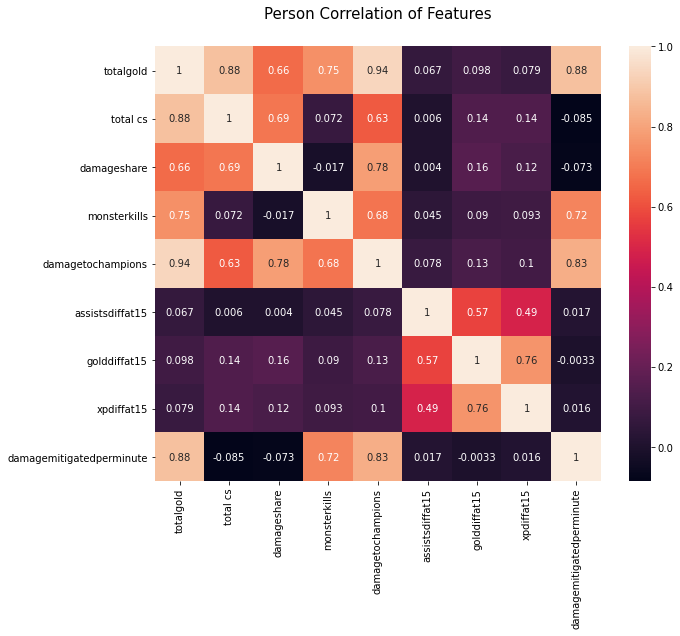

In [13]:
plt.figure(figsize=(10, 8))
plt.title("Person Correlation of Features", y = 1.05, size = 15)
sns.heatmap(summary_df[['totalgold','total cs', 'damageshare', 'monsterkills', 'damagetochampions', 'assistsdiffat15', \
    'golddiffat15', 'xpdiffat15', 'damagemitigatedperminute']].corr(), annot=True)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


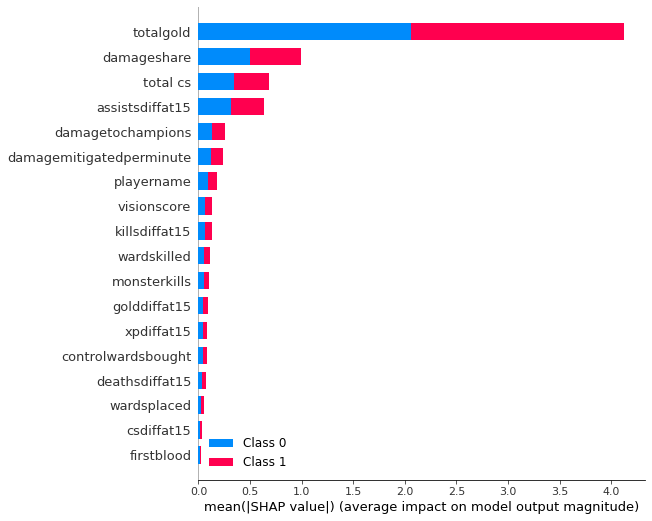

In [14]:
import shap
# load js 
shap.initjs()

'''
KernelExplainer() : KNN, SVM, RandomForest, GBM, H2O 
TreeExplainer() : tree-based machine learning model (faster) 
DeepExplainer() : deep learning model 
'''

explainer = shap.TreeExplainer(lgbm_warpper)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')

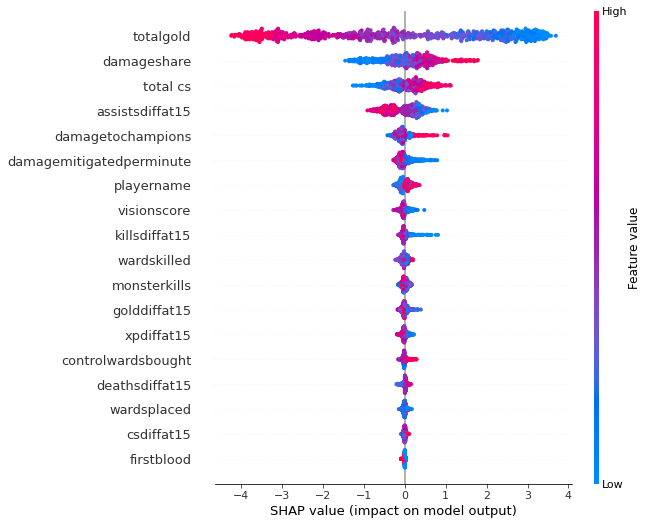

In [15]:
import shap
# load js 
shap.initjs()

'''
KernelExplainer() : KNN, SVM, RandomForest, GBM, H2O 
TreeExplainer() : tree-based machine learning model (faster) 
DeepExplainer() : deep learning model 
'''

explainer = shap.TreeExplainer(lgbm_warpper)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[0], X_train)